In [ ]:
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu126

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='data/cifar10-64/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='data/cifar10-64/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

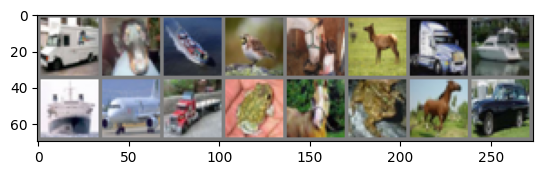

truck dog   ship  bird  horse deer  truck ship  ship  plane truck frog  horse frog  horse car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 250)
        self.fc2 = nn.Linear(250, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Playing on {device}")

net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Playing on cuda


In [5]:
for epoch in tqdm(range(10)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        

        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/10 [00:00<?, ?it/s]

[1,  2000] loss: 1.621


 10%|█         | 1/10 [00:10<01:35, 10.58s/it]

[2,  2000] loss: 1.264


 20%|██        | 2/10 [00:20<01:22, 10.34s/it]

[3,  2000] loss: 1.115


 30%|███       | 3/10 [00:31<01:12, 10.32s/it]

[4,  2000] loss: 1.022


 40%|████      | 4/10 [00:41<01:01, 10.26s/it]

[5,  2000] loss: 0.931


 50%|█████     | 5/10 [00:51<00:52, 10.43s/it]

[6,  2000] loss: 0.865


 60%|██████    | 6/10 [01:02<00:41, 10.35s/it]

[7,  2000] loss: 0.801


 70%|███████   | 7/10 [01:12<00:31, 10.35s/it]

[8,  2000] loss: 0.749


 80%|████████  | 8/10 [01:22<00:20, 10.31s/it]

[9,  2000] loss: 0.695


 90%|█████████ | 9/10 [01:33<00:10, 10.34s/it]

[10,  2000] loss: 0.651


100%|██████████| 10/10 [01:43<00:00, 10.36s/it]

Finished Training


In [6]:
PATH = 'models/cifar_net-v0.pth'
torch.save(net.state_dict(), PATH)

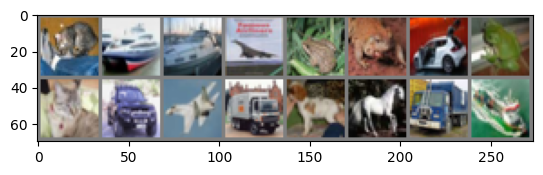

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

outputs = net(images)

In [8]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(labels))))

Predicted:  cat   ship  truck plane frog  frog  dog   frog  cat   car   plane truck dog   horse truck ship 


In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.3 %
Accuracy for class: car   is 71.1 %
Accuracy for class: bird  is 51.8 %
Accuracy for class: cat   is 44.7 %
Accuracy for class: deer  is 58.6 %
Accuracy for class: dog   is 51.8 %
Accuracy for class: frog  is 76.9 %
Accuracy for class: horse is 67.8 %
Accuracy for class: ship  is 73.0 %
Accuracy for class: truck is 68.3 %
